In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import matplotlib.pyplot as plt
from decimal import Decimal, ROUND_HALF_UP

Choose the experiment file source:

In [4]:
experiments = ["experiment_results/manual_vs_high-level.xlsx", "experiment_results/manual_vs_auto.xlsx"]
df = pd.read_excel(experiments[0])

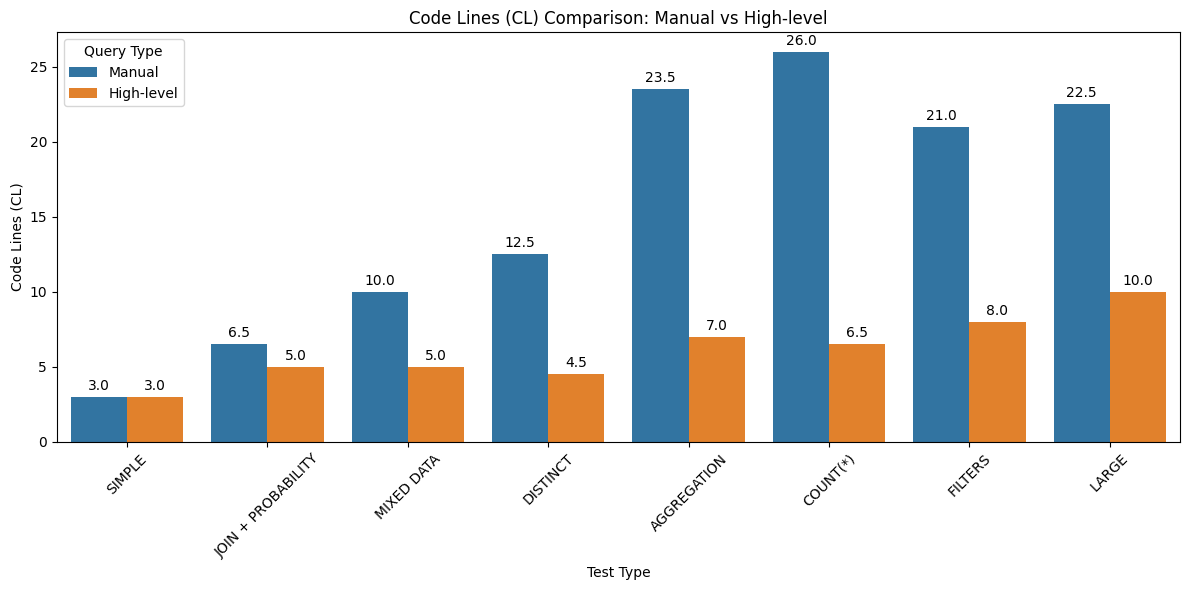

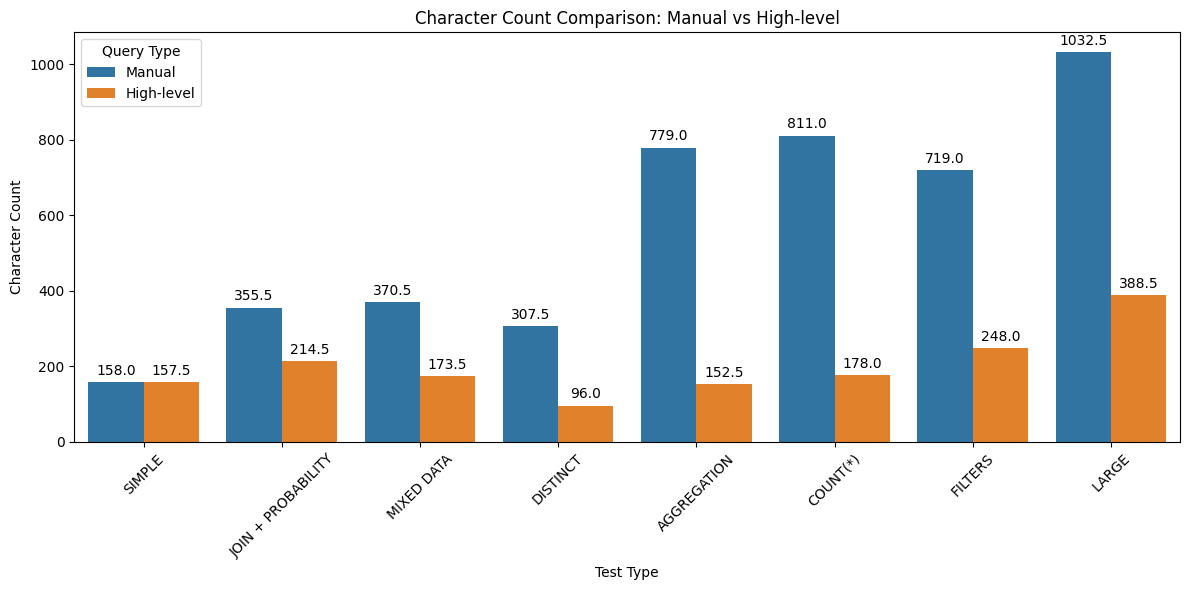

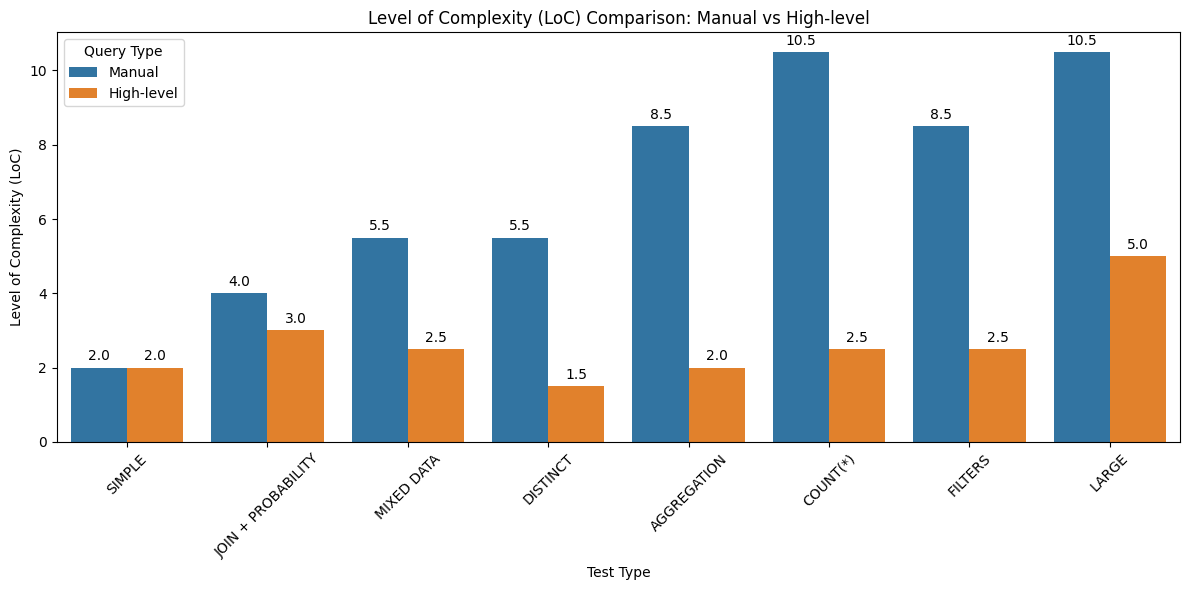

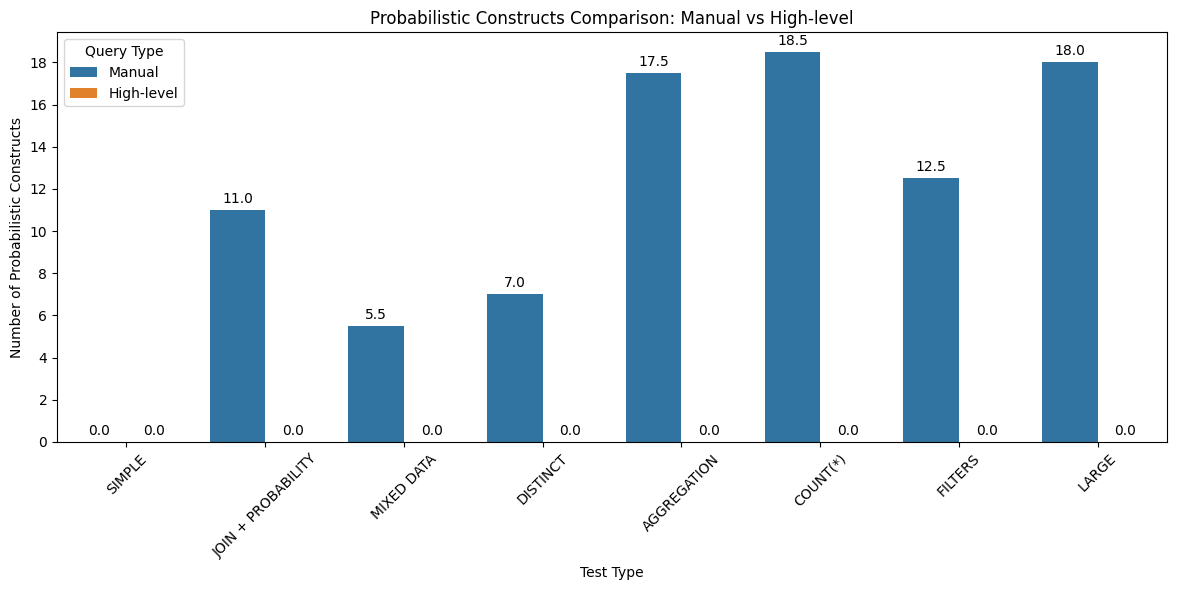

In [5]:
df.columns = [col.strip() for col in df.columns]
df["Test Type"] = df["Test Type"].ffill() # Fill NaN values in "Test Type" column with the last valid value

# Get the 2 out of the 3 types of queries - high-level, manual, or auto
# NOTE: the *odd* query types have *even* indexes, and the *even* query types have *odd* indexes!
odd_query = df["Test Query"][0].lower()
even_query = df["Test Query"][1].lower()
odd_query_type = "Manual" if "manual" in odd_query else "Automatic" if "auto" in odd_query else "High-level"
even_query_type = "Manual" if "manual" in even_query else "Automatic" if "auto" in even_query else "High-level"
df["Query Type"] = [
    odd_query_type if i % 2 == 0 else even_query_type
    for i in range(len(df))
]

# Reorder rows to make sense by complexity and length
order = [
    "SIMPLE",
    "JOIN + PROBABILITY",
    "MIXED DATA",
    "DISTINCT",
    "AGGREGATION",
    "COUNT(*)",
    "FILTERS",
    "LARGE",
]
df["Test Type"] = pd.Categorical(df["Test Type"], categories=order, ordered=True)
df = df.sort_values("Test Type").reset_index(drop=True)

# Create the directory if it doesn't exist
os.makedirs(f"{odd_query_type}_vs_{even_query_type}_diagrams", exist_ok=True)


# Plot 1: CL comparison
plt.figure(figsize=(12, 6))
ax = sns.barplot(data=df, x="Test Type", y="Code Lines (CL)", hue="Query Type", errorbar=None)
plt.title(f"Code Lines (CL) Comparison: {odd_query_type} vs {even_query_type}")
plt.ylabel("Code Lines (CL)")
plt.xticks(rotation=45)
plt.legend(title="Query Type")
plt.tight_layout()
ax = plt.gca()
for container in ax.containers:
    ax.bar_label(container, fmt='%.1f', padding=3)

plt.savefig(f"experiment_results/{odd_query_type}_vs_{even_query_type}_diagrams/{odd_query_type}_vs_{even_query_type}_cl_comparison.png", bbox_inches='tight')
plt.show()
plt.close()

# Plot 2: Character Count Comparison
plt.figure(figsize=(12, 6))
ax = sns.barplot(data=df, x="Test Type", y="Characters", hue="Query Type", errorbar=None)
plt.title(f"Character Count Comparison: {odd_query_type} vs {even_query_type}")
plt.ylabel("Character Count")
plt.xticks(rotation=45)
plt.legend(title="Query Type")
plt.tight_layout()
ax = plt.gca()
for container in ax.containers:
    ax.bar_label(container, fmt='%.1f', padding=3)

plt.savefig(f"experiment_results/{odd_query_type}_vs_{even_query_type}_diagrams/{odd_query_type}_vs_{even_query_type}_character_count_comparison.png", bbox_inches='tight')
plt.show()
plt.close()


# Plot 3: Level of Complexity (LoC) Comparison
plt.figure(figsize=(12, 6))
ax = sns.barplot(data=df, x="Test Type", y="Level of Complexity (LoC)", hue="Query Type", errorbar=None)
plt.title(f"Level of Complexity (LoC) Comparison: {odd_query_type} vs {even_query_type}")
plt.ylabel("Level of Complexity (LoC)")
plt.xticks(rotation=45)
plt.legend(title="Query Type")
plt.tight_layout()
ax = plt.gca()
for container in ax.containers:
    ax.bar_label(container, fmt='%.1f', padding=3)
    
plt.savefig(f"experiment_results/{odd_query_type}_vs_{even_query_type}_diagrams/{odd_query_type}_vs_{even_query_type}_loc_comparison.png", bbox_inches='tight')
plt.show()
plt.close()


# Plot 4: Prob Constructs are obvious, but still plot for consistency
plt.figure(figsize=(12, 6))
ax = sns.barplot(data=df, x="Test Type", y="Probabilistic Constructs", hue="Query Type", errorbar=None)
plt.title(f"Probabilistic Constructs Comparison: {odd_query_type} vs {even_query_type}")
plt.ylabel("Number of Probabilistic Constructs")
plt.xticks(rotation=45)
plt.legend(title="Query Type")
plt.tight_layout()

# Set y-axis labels to int safely
ax.yaxis.set_major_locator(plt.MaxNLocator(integer=True))

# Add value labels to the bars since there are some 0 values
ax = plt.gca()
for container in ax.containers:
    ax.bar_label(container, fmt='%.1f', padding=3)

plt.savefig(f"experiment_results/{odd_query_type}_vs_{even_query_type}_diagrams/{odd_query_type}_vs_{even_query_type}_probabilistic_constructs_comparison.png", bbox_inches='tight')
plt.show()
plt.close()

In [6]:
odd_rows = df[df["Query Type"] == odd_query_type].copy().reset_index(drop=True)
even_rows = df[df["Query Type"] == even_query_type].copy().reset_index(drop=True)

# Construct the comparison DataFrame
comparison_df = pd.DataFrame()
comparison_df["Query Type"] = odd_rows["Test Type"]
comparison_df[f"{odd_query_type} CL"] = odd_rows["Code Lines (CL)"]
comparison_df[f"{even_query_type} CL"] = even_rows["Code Lines (CL)"]
comparison_df[f"{odd_query_type} Characters"] = odd_rows["Characters"]
comparison_df[f"{even_query_type} Characters"] = even_rows["Characters"]
comparison_df[f"{odd_query_type} Complexity"] = odd_rows["Level of Complexity (LoC)"]
comparison_df[f"{even_query_type} Complexity"] = even_rows["Level of Complexity (LoC)"]
comparison_df[f"Probabilistic Constructs ({odd_query_type})"] = odd_rows["Probabilistic Constructs"]
comparison_df[f"Probabilistic Constructs ({even_query_type})"] = even_rows["Probabilistic Constructs"]

# Group by Query Type and aggregate
grouped = comparison_df.groupby("Query Type", observed=False).agg({
    f"{odd_query_type} CL": "mean",
    f"{even_query_type} CL": "mean",
    f"{odd_query_type} Characters": "mean",
    f"{even_query_type} Characters": "mean",
    f"{odd_query_type} Complexity": "mean",
    f"{even_query_type} Complexity": "mean",
    f"Probabilistic Constructs ({odd_query_type})": "sum",
    f"Probabilistic Constructs ({even_query_type})": "sum"
}).reset_index()


# Use Decimal and ROUND_HALF_UP for all rounding. Otherwise, for example, 2.5 is rounded to 2 instead of 3
def round_half_up(val):
    return int(Decimal(val).to_integral_value(rounding=ROUND_HALF_UP))

grouped["CL Reduction %"] = (
    ((grouped[f"{odd_query_type} CL"] - grouped[f"{even_query_type} CL"]) / grouped[f"{odd_query_type} CL"] * 100)
    .apply(round_half_up).astype(int).astype(str) + '%'
)
grouped["Characters Reduction %"] = (
    ((grouped[f"{odd_query_type} Characters"] - grouped[f"{even_query_type} Characters"]) / grouped[f"{odd_query_type} Characters"] * 100)
    .apply(round_half_up).astype(int).astype(str) + '%'
)
grouped["Complexity Reduction %"] = (
    ((grouped[f"{odd_query_type} Complexity"] - grouped[f"{even_query_type} Complexity"]) / grouped[f"{odd_query_type} Complexity"] * 100)
    .apply(round_half_up).astype(int).astype(str) + '%'
)
# NOTE: Since the high-level queries contain no probabilistic constructs, the reduction is calculated as the difference
# between the two types of queries, not as a percentage.
grouped["Prob Constructs Reduction #"] = (
    (grouped[f"Probabilistic Constructs ({odd_query_type})"] - grouped[f"Probabilistic Constructs ({even_query_type})"])
    .apply(round_half_up).astype(int).astype(str)
)


def percent_to_int(series):
    return series.str.replace('%', '').astype(int)

def create_overall_row(df):
    overall_row = {
        "Query Type": "Overall Reduction",
        "CL Reduction %": f"{round_half_up(percent_to_int(df['CL Reduction %']).mean())}%",
        "Characters Reduction %": f"{round_half_up(percent_to_int(df['Characters Reduction %']).mean())}%",
        "Complexity Reduction %": f"{round_half_up(percent_to_int(df['Complexity Reduction %']).mean())}%",
        "Prob Constructs Reduction #": f"{round_half_up(df['Prob Constructs Reduction #'].astype(int).mean())}"
    }
    return overall_row

grouped = pd.concat([grouped, pd.DataFrame([create_overall_row(grouped)])], ignore_index=True)

grouped_reduction = grouped[[
    "Query Type",
    "CL Reduction %", "Characters Reduction %", "Complexity Reduction %",
    "Prob Constructs Reduction #"
]]

display(grouped_reduction)

,Query Type,CL Reduction %,Characters Reduction %,Complexity Reduction %,Prob Constructs Reduction #
0,SIMPLE,0%,0%,0%,0
1,JOIN + PROBABILITY,23%,40%,25%,22
2,MIXED DATA,50%,53%,55%,11
3,DISTINCT,64%,69%,73%,14
4,AGGREGATION,70%,80%,76%,35
5,COUNT(*),75%,78%,76%,37
6,FILTERS,62%,66%,71%,25
7,LARGE,56%,62%,52%,36
8,Overall Reduction,50%,56%,54%,23


In [7]:
# Make a copy of the df and drop the simple and join test types
df_grouped = grouped.copy()
df_grouped = df_grouped[~df_grouped["Query Type"].isin(["SIMPLE", "JOIN + PROBABILITY", "Overall Reduction"])].reset_index(drop=True)

df_grouped = pd.concat([df_grouped, pd.DataFrame([create_overall_row(df_grouped)])], ignore_index=True)

df_grouped_reduction = df_grouped[[
    "Query Type",
    "CL Reduction %", "Characters Reduction %", "Complexity Reduction %",
    "Prob Constructs Reduction #"
]]

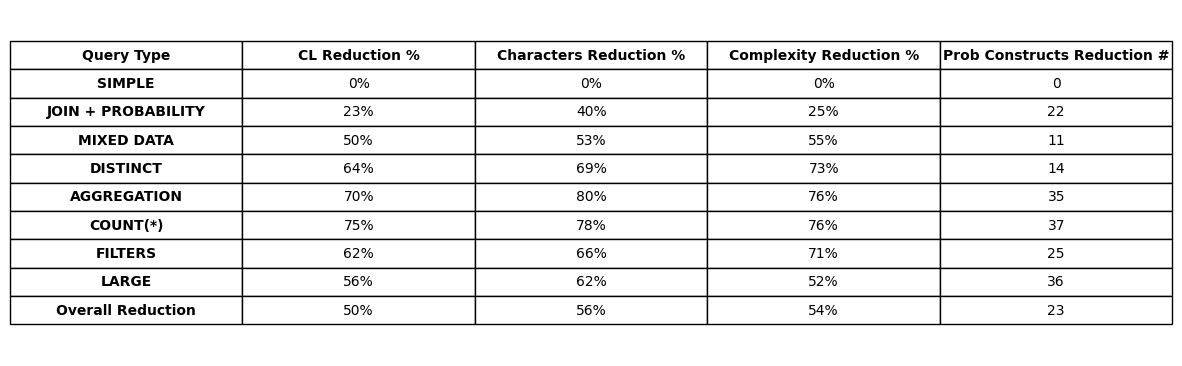

In [ ]:
def save_df_as_image(simple=""):
    df = grouped_reduction if simple == "" else df_grouped_reduction
    fig, ax = plt.subplots(figsize=(len(df.columns) * 1.2, len(df) * 0.5))
    ax.axis('off')
    table = ax.table(cellText=df.values, colLabels=df.columns, cellLoc='center', loc='center')
    table.auto_set_font_size(False)
    table.set_fontsize(10)
    table.scale(2.5, 1.7)
    # Bold headers
    for (row, col), cell in table.get_celld().items():
        if row == 0 or col == 0:
            cell.set_text_props(weight='bold')
    plt.savefig(f"experiment_results/{odd_query_type}_vs_{even_query_type}_diagrams/{odd_query_type}_vs_{even_query_type}_table{simple}.png", bbox_inches='tight')
    plt.show()
    plt.close()

no_simple_queries = "_no_simple" # Otherwise, omit it in the function below to include simple queries (SIMPLE and JOIN) in the final reduction table
save_df_as_image(no_simple_queries)